# Gene enrichment exploration
Here, we investigate the enrichment scores obtained in 09_gene_enrichment_scoring_datadrivencells_rbf_8e-1.py that uses the log-normalized data matrix that is log-transformed from the normalized matrix in 06_logc_transformation.py and saved as .h5 files in 07_save_mats_as_h5.py

## 1. Set up the notebook

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.sparse import csr_matrix
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.support_funcs import sig_dictionary, load_sparse_h5

In [2]:
os.chdir("../data/processed/")

## 2. Load the data

We load the log-transformed and normalized data for visualization of single genes

In [3]:
X = load_sparse_h5("scRNA", "greenleaf_scRNA_combined_expressed_logcnorm.h5")
X = X.tocsr()

We load the gene names

In [4]:
with open("greenleaf_scRNA_combined_expressed_genes.txt", "r") as f:
    genes = [g.strip("\n") for g in f.readlines()]
f.close()

We load the 2D UMAP for visualizations

In [5]:
UMAP = np.load("greenleaf_scRNA_combined_umap.npy")

We load the reference cells

In [6]:
with open("greenleaf_scRNA_cells_selected_from_knn.txt", "r") as f:
    r_cells = [int(c.strip("\n")) for c in f.readlines()]
f.close()

We load the enrichment scores

In [7]:
ESCORES = pd.read_csv("greenleaf_scRNA_escores_knn_rbf_8e-1.txt", sep="\t",
                      index_col=0)

We load the null distribution scores

In [8]:
PSCORES = pd.read_csv("../interim/greenleaf_scRNA_pscores_knn_rbf_8e-1.txt",
                      sep="\t", index_col=0)

## 3. Get signficantly enriched genes

Determine the cut off below and above which genes are declared signficant

In [9]:
interval = sig_interval(PSCORES, n_sds=25)

Construct a dictionary of significant genes

In [10]:
sigdict = sig_dictionary(ESCORES, interval)

## 4. Visualize the top genes for a random subset of cells

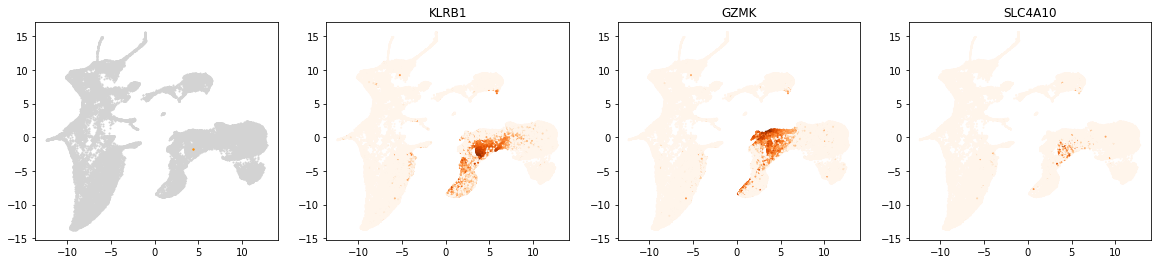

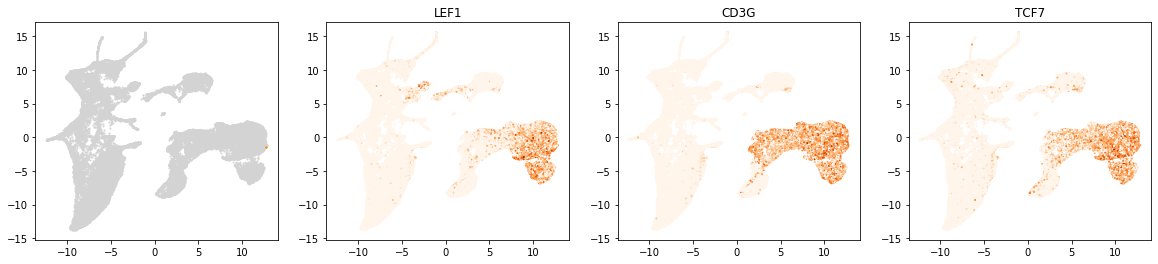

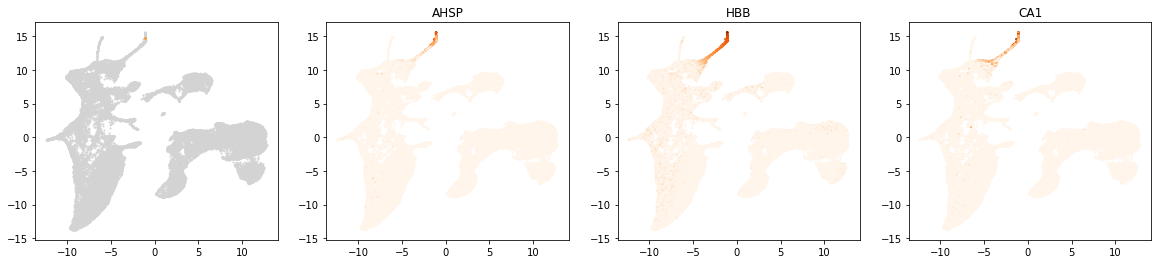

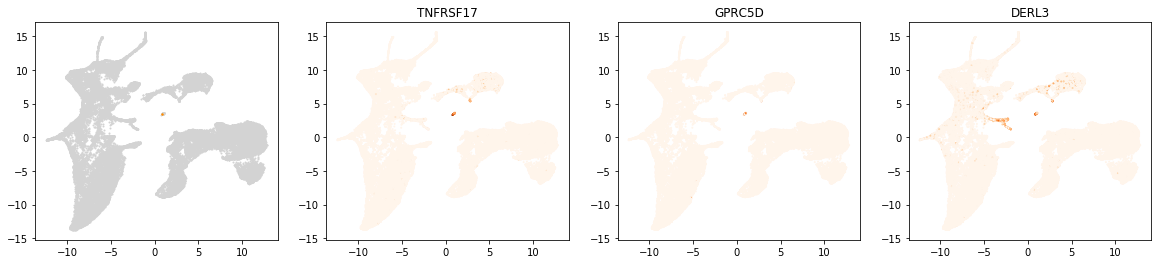

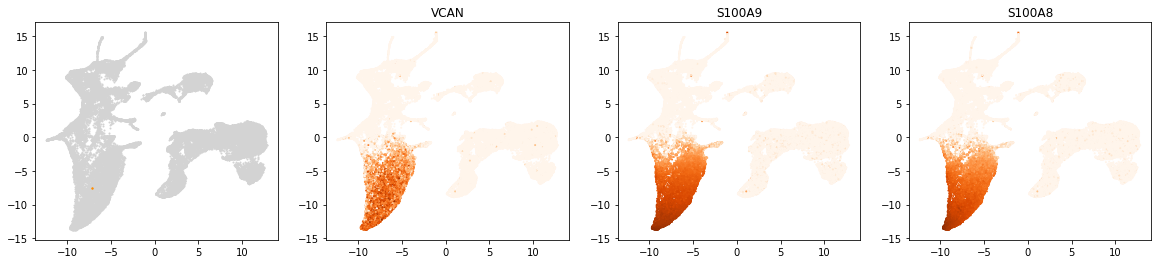

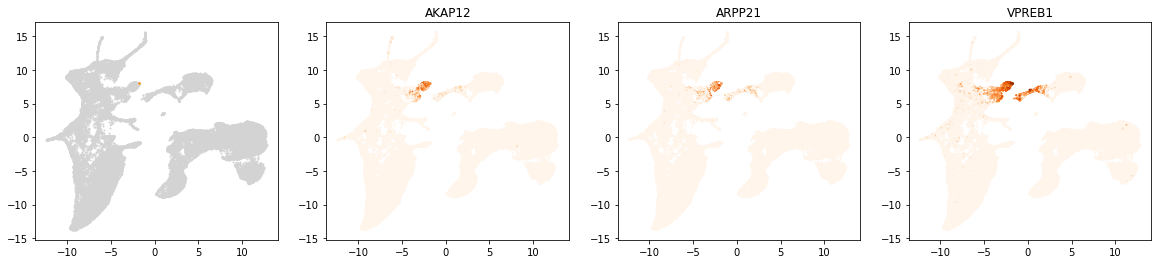

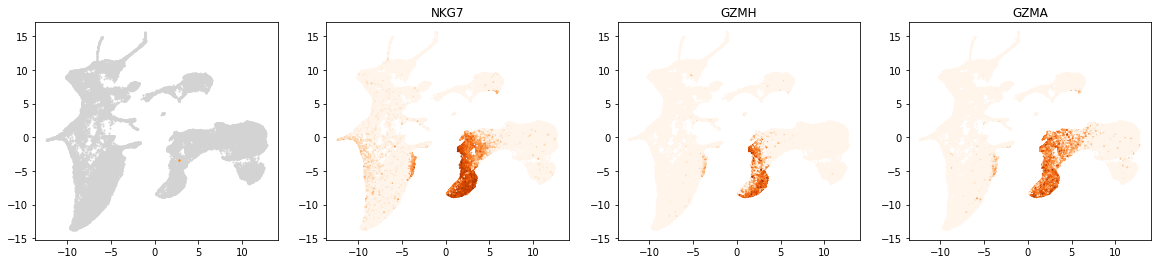

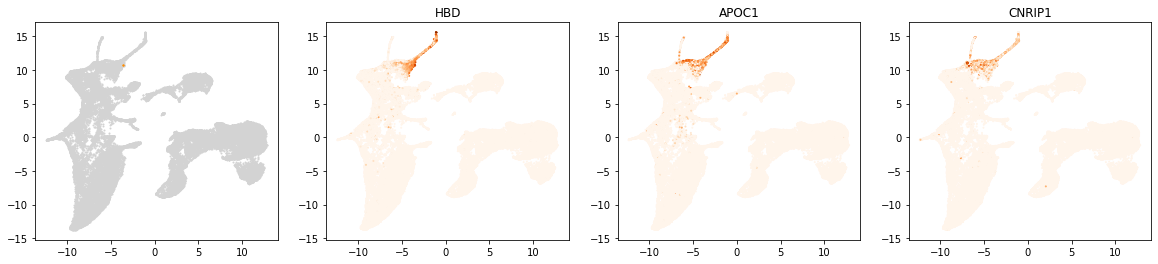

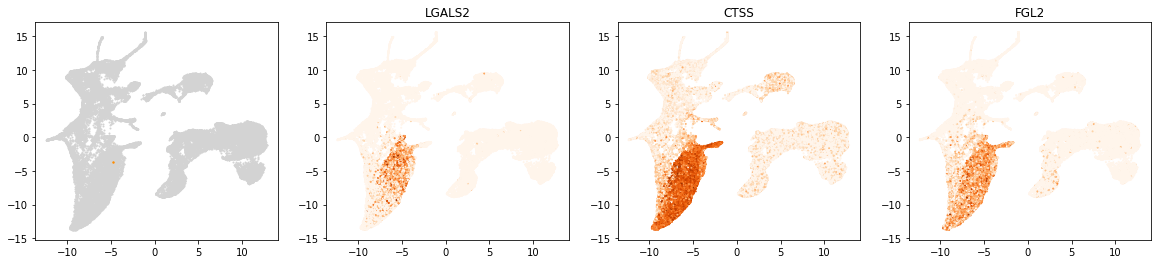

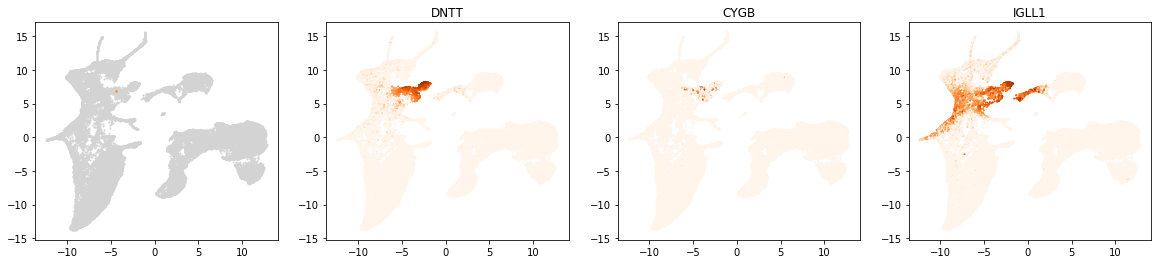

In [11]:
np.random.seed(42)
for i in np.random.choice(range(0, 75), size=10, replace=False):
    top = ESCORES.iloc[:, i].sort_values(ascending=False).index
    fig, axs = plt.subplots(1, 4)
    fig.set_figwidth(20)
    axs[0].scatter(UMAP[:, 0], UMAP[:, 1], s=1, color="lightgrey")
    axs[0].scatter(UMAP[r_cells[i], 0], UMAP[r_cells[i], 1], s=2,
                   color="darkorange")
    for gene, ax in zip(top, axs[1:4]):
        ax.scatter(UMAP[:, 0], UMAP[:, 1], s=1,
                   c=X[:, genes.index(gene)].data, cmap="Oranges")
        ax.set_title(gene)
    plt.show()

We see that we identify genes that are stricly expressed in certain cell neighbourhoods. Based on these markers, we now annotate every reference cell.

## 5. Visualize annotations

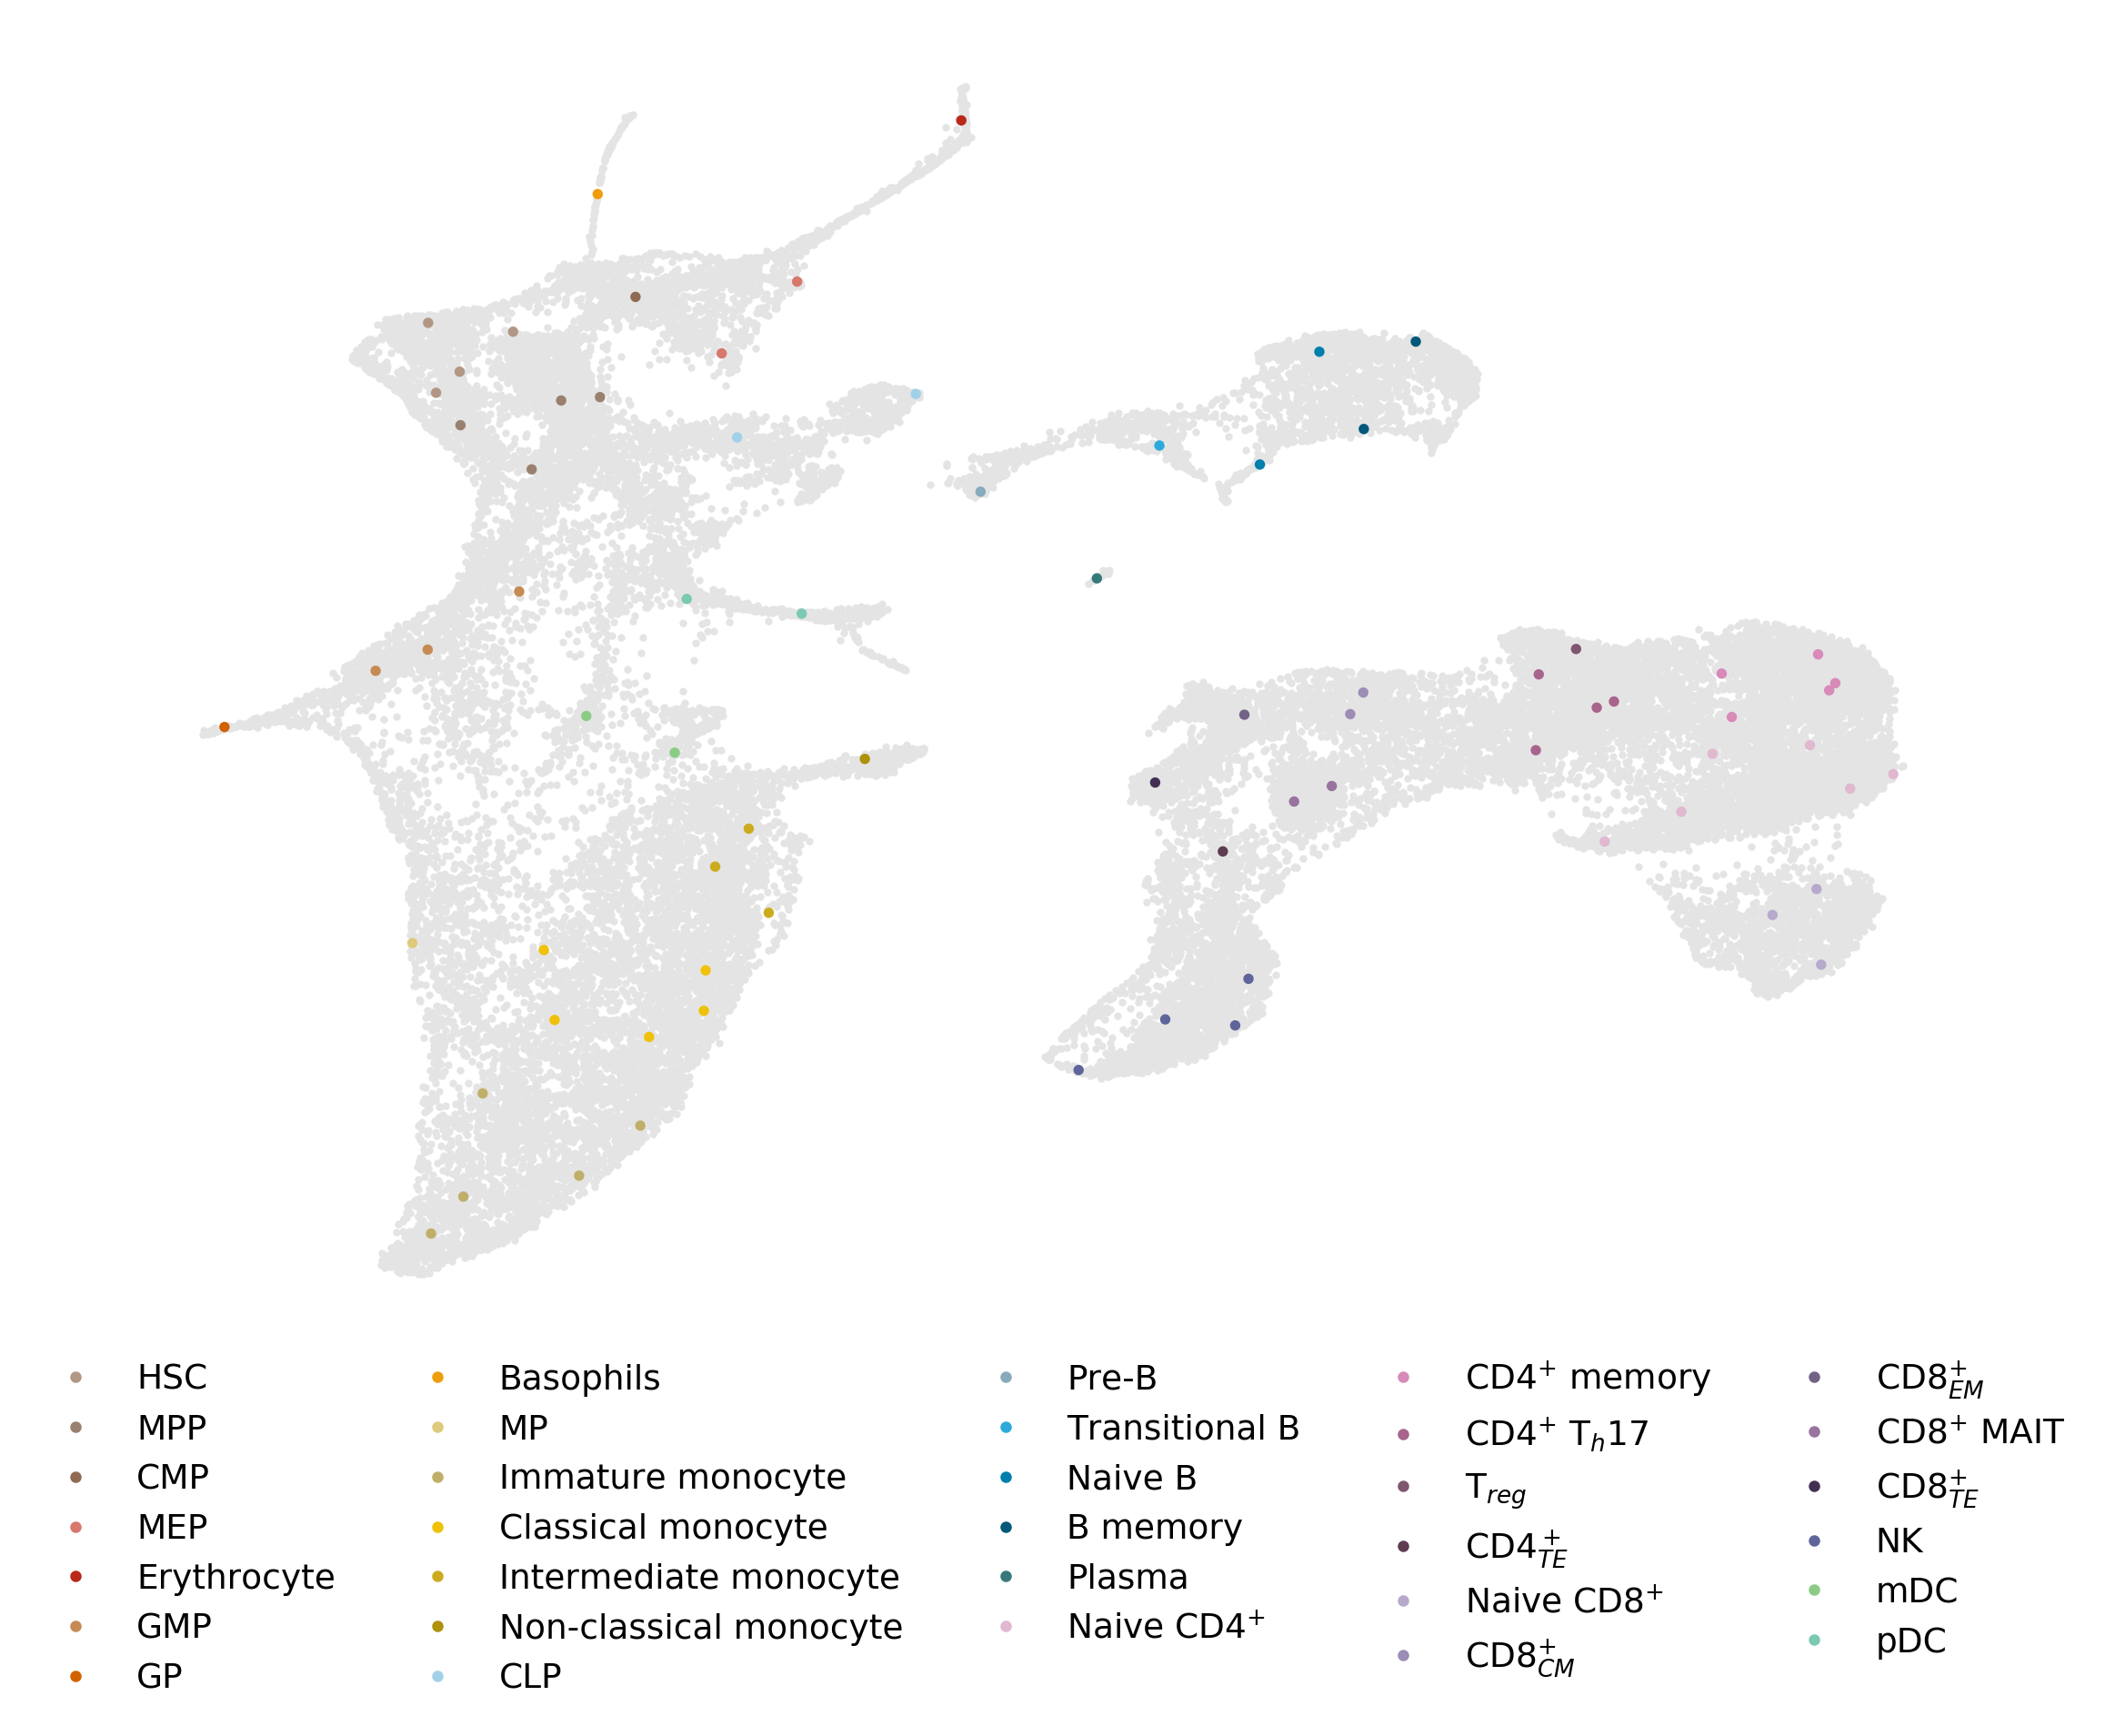

In [12]:
params = {"mathtext.default": "regular"}
order = ["HSC", "MPP",
         "CMP", "MEP", "ERYTHROCYTE",
         "GMP", "GP", "BASO",
         "MP", "IMMATURE MONO_CLAS", "MONO_CLAS", "MONO_INT", "MONO_NONCLAS",
         "CLP", "PRE_B", "B_TRANSITIONAL", "B_NAIVE", "B_MEMORY", "PLASMA",
         "CD4_NAIVE", "CD4_MEMORY", "CD4_TH17", "T_REG", "CD4_TERM_EFFECT",
         "CD8_NAIVE", "CD8_CENTRAL_MEMORY", "CD8_EFFECTOR_MEMORY", "CD8_MAIT",
         "CD8_TERM_EFFECT", "NK", "mDC", "pDC"]
labels = ["HSC", "MPP",
          "CMP", "MEP", "Erythrocyte",
          "GMP", "GP", "Basophils",
          "MP",  "Immature monocyte", "Classical monocyte", "Intermediate monocyte",
          "Non-classical monocyte",
          "CLP", "Pre-B", "Transitional B", "Naive B", "B memory", "Plasma",
          r"Naive CD4$^{+}$", r"CD4$^{+}$ memory", r"CD4$^{+}$ T$_{h}$17",
          r"T$_{reg}$", "CD4$^+_{TE}$",
          r"Naive CD8$^{+}$", r"CD8$^{+}_{CM}$",
          r"CD8$^{+}_{EM}$", r"CD8$^{+}$ MAIT", r"CD8$^{+}_{TE}$", "NK", "mDC", "pDC"]
annots = pd.read_csv("greenleaf_scRNA_knn_rbf_8e1_annotations.csv", sep="\t")
annots = annots.replace(dict(zip(order, labels)))
order = labels
colors = list(annots.COLOUR)
labels = annots.ANNOT
ids = [int(i) for i in annots.ID]

coldict = dict(zip(annots.ANNOT, annots.COLOUR))
legend = {k: coldict[k] for k in order}
marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="", markersize=2)
          for c in legend.values()]

plt.figure(figsize=(8.27, 6.5), dpi=300)
plt.scatter(UMAP[:, 0], UMAP[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP[annots.ID, 0], UMAP[annots.ID, 1], c=annots.COLOUR.values, s=3)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)

leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=9, ncol=5,
                 loc="lower center", bbox_to_anchor=(0.5, -0.3))
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

## 6. Subset cells for gene set enrichment scoring
Next, we want to do gene set enrichment scoring. Because the total number of gene sets is very large. Therefore, we select one cell of each annotation based on in which cell its marker is most highly enriched.

We list the markers

In [13]:
markers = {"HSC": "AVP",
           "MPP": "SPINK2",
           "CMP": "GATA2",
           "MEP": "CNRIP1",
           "ERYTHROCYTE": "HBB",
           "GMP": "PRSS57",
           "GP": "CTSG",
           "BASO": "HDC",
           "MP": "RETN",
           "IMMATURE MONO_CLAS": "S100A9",
           "MONO_CLAS": "VCAN",
           "MONO_INT": "SAT1",
           "MONO_NONCLAS": "C1QA",
           "CLP": "AKAP12", 
           "PRE_B": "VPREB1", 
           "B_TRANSITIONAL": "DTX1",
           "B_NAIVE": "TCL1A",
           "B_MEMORY": "MS4A1",
           "PLASMA": "TNFRSF17",
           "CD4_NAIVE": "LEF1",
           "CD4_MEMORY": "LTB",
           "CD4_TH17": "TNFRSF4",
           "T_REG": "DUSP4",
           "CD4_TERM_EFFECT": "GZMH",  # + CD4,
           "CD8_NAIVE": "NELL2",
           "CD8_MAIT": "SLC4A10",
           "CD8_CENTRAL_MEMORY": "CCL5",
           "CD8_EFFECTOR_MEMORY": "DUSP2",
           "CD8_TERM_EFFECT": "NKG7",
           "NK": "GNLY",
           "pDC": "LILRA4",
           "mDC": "ENHO"}

We select the subset of cells

In [14]:
annots = pd.read_csv("greenleaf_scRNA_knn_rbf_8e1_annotations.csv", sep="\t")

In [15]:
selection = {}
for a in np.unique(annots.ANNOT):  # for each annotation
    m = markers[a]  # select the marker
    idxs = annots[annots.ANNOT == a].ID.values.astype(str)  # select the cells
    selection[a] = int(idxs[np.argmax(ESCORES.loc[m, idxs])])  # get the max enriched

Now, we visualize which cells are selected

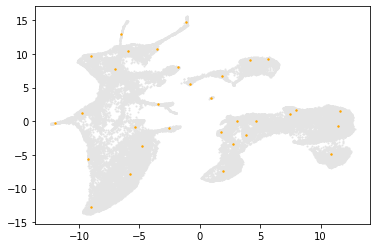

In [16]:
plt.scatter(UMAP[:, 0], UMAP[:, 1], c="#e4e4e4", s=1)
plt.scatter(UMAP[list(selection.values()), 0],
            UMAP[list(selection.values()), 1],
            c="orange", s=2)

... and save them to a file

In [17]:
with open("greenleaf_scRNA_cells_selected_from_knn_subset.txt", "w") as f:
    for c in selection.values():
        f.write("{0}\n".format(c))
f.close()

## 6. Construct gene sets for scoring

Now, we supply a subset of genes for each cell

In [18]:
genesets = {}
for c in selection.values():
    sigs = sigdict[str(c)]  # signficant genes in cell c
    idxs = np.where(np.isin(ESCORES.index, sigs))[0]  # indices of the signficant genes
    genesets[c] = list(combinations(idxs, 2))  # all possible combinations of indices in cell c
with open("greenleaf_scRNA_knn_subset_sd25_8e-1_genesets.pkl", "wb") as f:
    pickle.dump(genesets, f)
f.close()